# Learn VoC
### Pola Methodology

In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batterySet = pickle.load(open("./Battery_Data/new_battery_cycles/new_battery_v2.p", 'rb'))

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

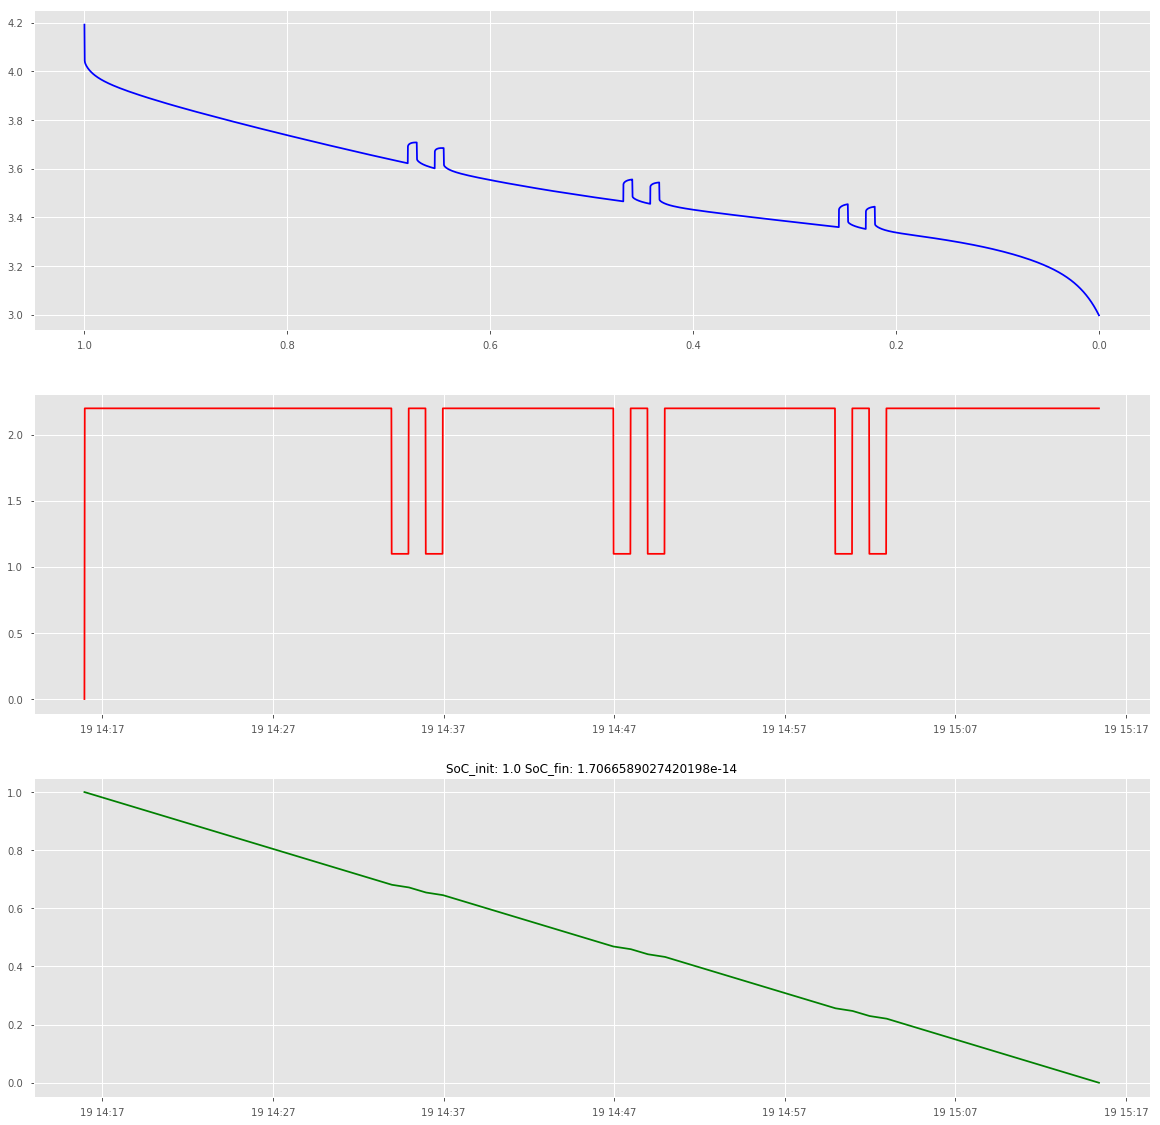

In [4]:
charSet = batterySet[1]
current = np.array(charSet['Current'], ndmin=2)*-1.0
seconds = np.ones_like(current)
C_n = np.sum(current*seconds)
SoC = []
SoC_state = 1.0
SoC_init = SoC_state
for i in range(current.shape[1]):
    SoC_state -= current[0, i]/C_n
    SoC.append(SoC_state)

Characterisation_Set = {}
Characterisation_Set['C_n'] = C_n
Characterisation_Set['SoC'] = np.array(SoC, ndmin=2)
Characterisation_Set['Current'] = current
Characterisation_Set['Voltage'] = charSet['Voltage']

matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
plt.figure("SoC Estimate")
plt.subplot(311)
plt.plot(SoC, charSet['Voltage'].T, '-b')
plt.gca().invert_xaxis()
plt.subplot(312)
plt.plot(charSet['datetime'].T, current.T, '-r')
plt.subplot(313)
plt.title("SoC_init: {0} SoC_fin: {1}".format(SoC_init, SoC[-1]))
plt.plot(charSet['datetime'].T, np.array(SoC), '-g')

## Define VoC
$|Z_p | = |\Delta V / \Delta I|$, assuming $v oc ( k ) = v ( k ) + i ( k )· Z_p$

In [5]:
high_low_index = []
low_high_index = []
for i in range(1, current.shape[1] - 1):
    if current[0, i] - current[0, i + 1] > 0.001:
        print("High -> Low", current[0, i], current[0, i+1])
        high_low_index.append(i)
    elif current[0, i + 1] - current[0, i] > 0.001:
        print("Low -> High", current[0, i], current[0, i+1])
        low_high_index.append(i)

High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09794 2.19783
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19783 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784


In [6]:
delta_V = np.abs(charSet['Voltage'][0, high_low_index]-charSet['Voltage'][0, low_high_index])
delta_I = np.abs(current[0, high_low_index]-current[0, low_high_index])
delta_Z = delta_V/delta_I
Z_p = np.mean(delta_Z)
print(Z_p)
print(high_low_index)
print(low_high_index)

0.08076263685971334
[1080, 1200, 1860, 1980, 2640, 2760]
[1140, 1260, 1920, 2040, 2700, 2820]


## Zone 2



In [7]:
SoC = np.array(SoC, ndmin=2)
voltage = charSet['Voltage']

(1, 2846) <class 'numpy.ndarray'>
(1, 2846) <class 'numpy.ndarray'>
(1, 2846) <class 'numpy.ndarray'>


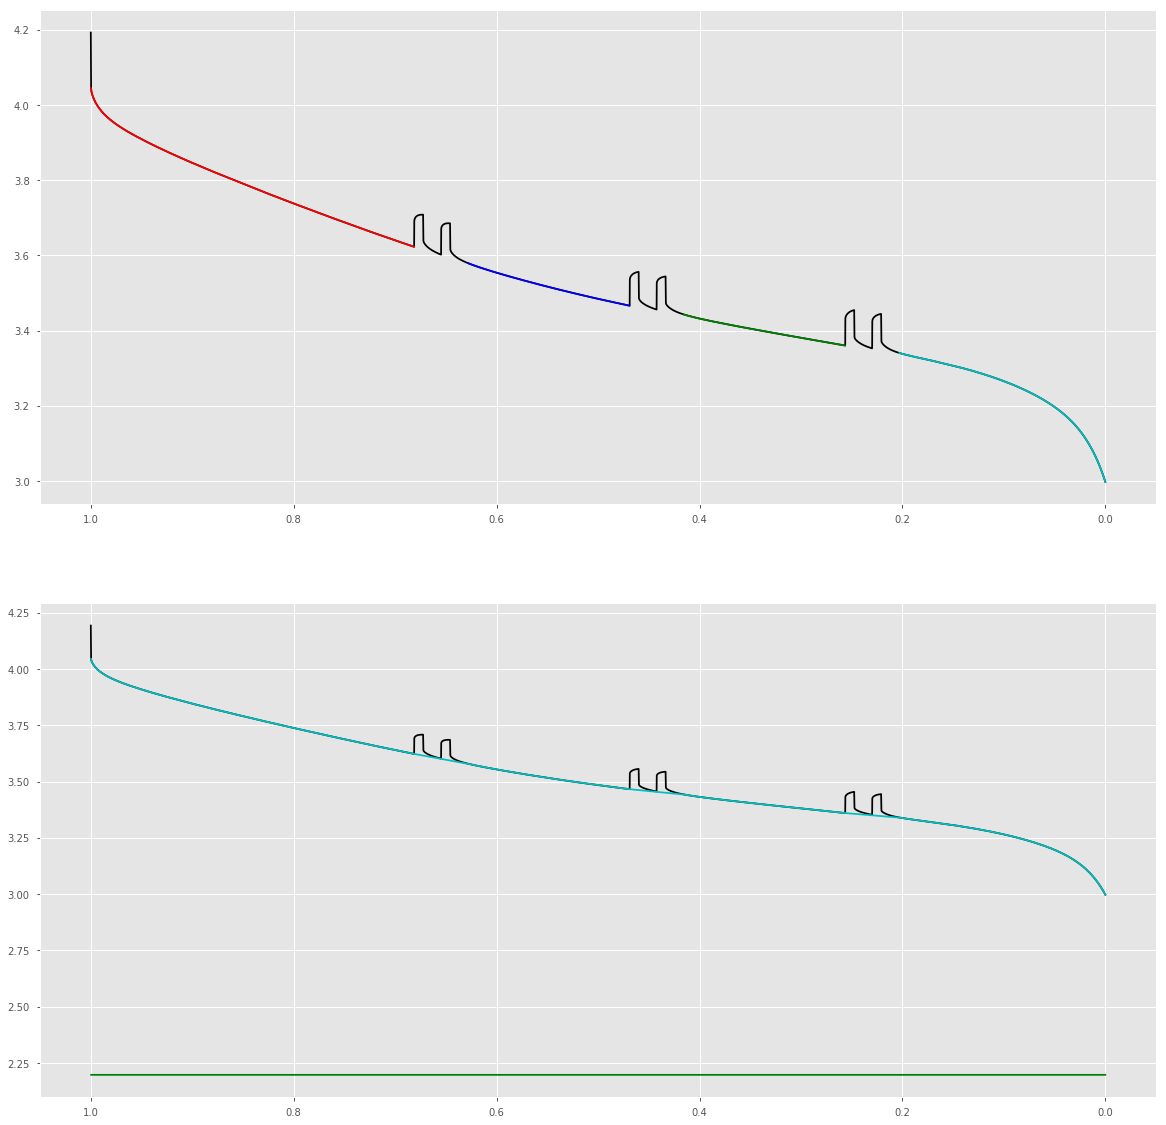

In [8]:
delta_t = low_high_index[0] + 1 - high_low_index[0]

l1_soc = SoC[0, 1:high_low_index[0]]
l1_v = voltage[0, 1:high_low_index[0]]
l1_current = current[0, 1:high_low_index[0]]

l2_soc = SoC[0, low_high_index[1]+delta_t:high_low_index[2]]
l2_v = voltage[0, low_high_index[1]+delta_t:high_low_index[2]]
l2_current = current[0, low_high_index[1]+delta_t:high_low_index[2]]

l3_soc = SoC[0, low_high_index[3]+delta_t:high_low_index[4]]
l3_v = voltage[0, low_high_index[3]+delta_t:high_low_index[4]]
l3_current = current[0, low_high_index[3]+delta_t:high_low_index[4]]

l4_soc = SoC[0, low_high_index[5]+delta_t:]
l4_v = voltage[0, low_high_index[5]+delta_t:]
l4_current = current[0, low_high_index[5]+delta_t:]

SoC_smoothed = np.array(np.concatenate((l1_soc, l2_soc, l3_soc, l4_soc)), ndmin=2)
print(SoC_smoothed.shape, type(SoC_smoothed))
V_smoothed = np.array(np.concatenate((l1_v, l2_v, l3_v, l4_v), axis=1), ndmin=2)
print(V_smoothed.shape, type(V_smoothed))
Current_smoothed = np.array(np.concatenate((l1_current, l2_current, l3_current, l4_current)), ndmin=2)
print(Current_smoothed.shape, type(Current_smoothed))

plt.subplot(211)
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(l1_soc.T, l1_v.T, '-r')
plt.plot(l2_soc.T, l2_v.T, '-b')
plt.plot(l3_soc.T, l3_v.T, '-g')
plt.plot(l4_soc.T, l4_v.T, '-c')
plt.gca().invert_xaxis()
plt.subplot(212)
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(SoC_smoothed.T, V_smoothed.T, '-c')
plt.plot(SoC_smoothed.T, Current_smoothed.T, '-g')
plt.gca().invert_xaxis()


In [9]:
from PSO.Canonical import Objective, VonNeumannTopology, FIPS_PSO, functional_test

In [10]:
def VoC(SoC, theta):
    v_L = theta[0]
    Lambda = theta[1]
    beta = theta[2]
    gamma = theta[3]
    mu = theta[4]
    return v_L + Lambda*np.exp(gamma*SoC) - mu*np.exp(-beta*np.sqrt(SoC))

def RSME_V(x, args=[]):
    V_est = VoC(SoC_smoothed, x) - Current_smoothed*0.0801
    RSME = np.sqrt(np.mean(np.power(V_est - V_smoothed, 2.0)))
    return float(RSME)

Finished Optimising ( 0.47322736463320325  min)
Best Position: [[ 4.07868684]
 [-0.82139589]
 [19.59709541]
 [-1.81105844]
 [ 0.11916814]]
Best Score: 0.07749037764154622


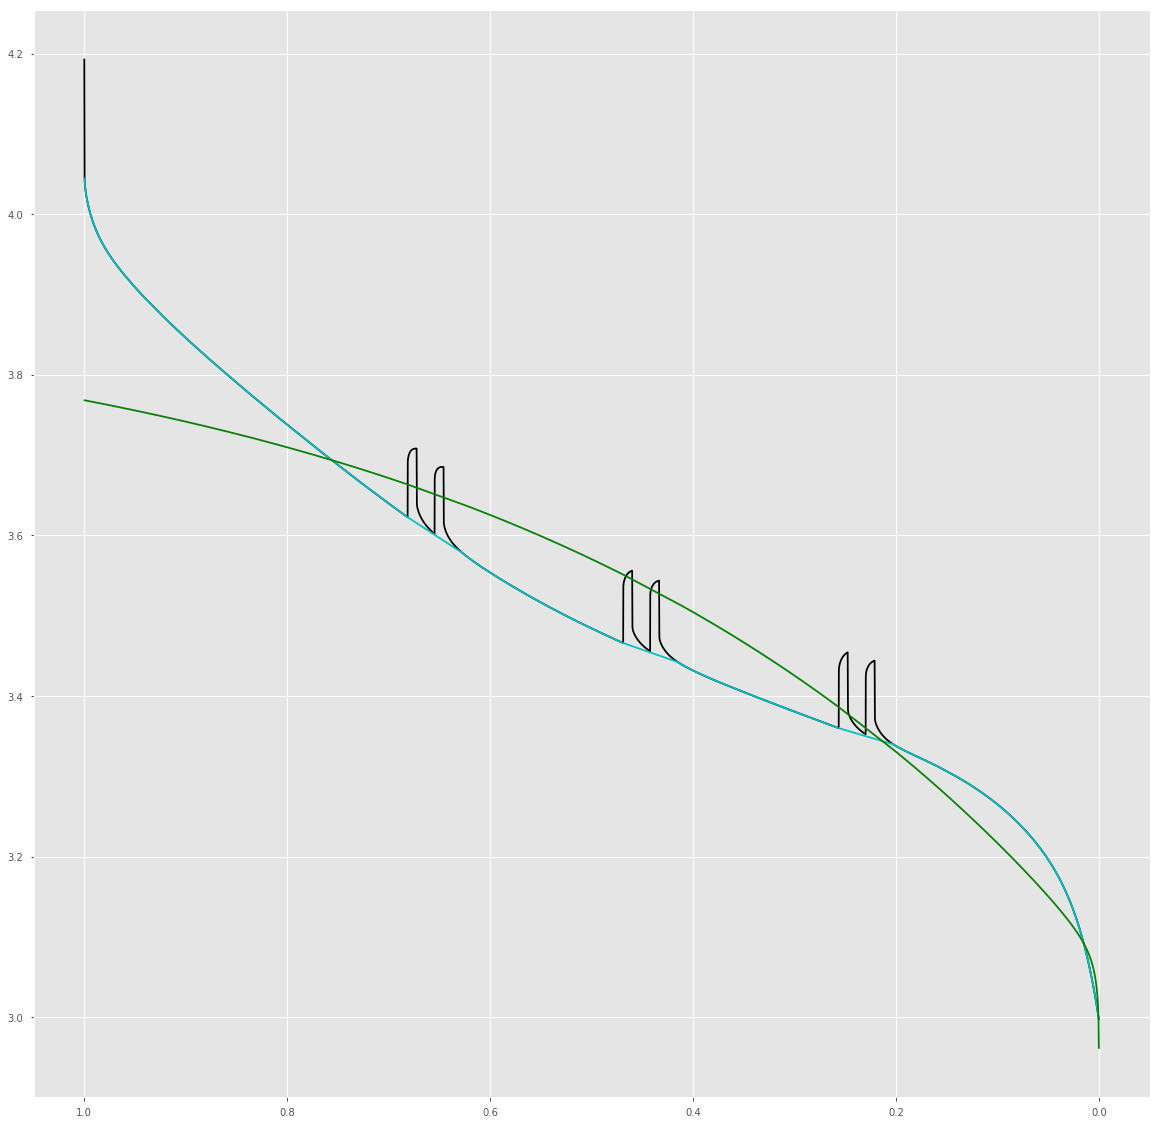

In [11]:
obj = Objective(RSME_V, (0, 20), 5, boundaries=True)
topology = VonNeumannTopology()
pso = FIPS_PSO(obj, topology)
best = pso.optimise(max_iterations=5000, verbose=False)
print('Best Position:', str(best))
print('Best Score:', str(pso.global_best_score))

V_est = VoC(SoC_smoothed, best) - Current_smoothed*0.0801
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(SoC_smoothed.T, V_smoothed.T, '-c')
plt.plot(SoC_smoothed.T, V_est.T, '-g')
plt.gca().invert_xaxis()